In [1]:
import os
import numpy as np
import unicodedata

# Ruta base
ruta_base = '/Users/Leon/Documents/Data GH/Aprendizaje automático /T4/data_tarea/train'
ruta_base = unicodedata.normalize('NFC', ruta_base)

train = []

# Recorrer cada subcarpeta (clase)
for clase in os.listdir(ruta_base):
    ruta_clase = os.path.join(ruta_base, clase)
    
    if os.path.isdir(ruta_clase):
        ruta_features = os.path.join(ruta_clase, 'features')
        
        if os.path.isdir(ruta_features):
            descriptores_clase = []
            
            for archivo in os.listdir(ruta_features):
                if archivo.endswith('.npy'):
                    ruta_archivo = os.path.join(ruta_features, archivo)
                    try:
                        datos = np.load(ruta_archivo)
                        if datos.shape[1] == 128:
                            descriptores_clase.append(datos)
                    except Exception as e:
                        print(f"Error cargando {ruta_archivo}: {e}")
            
            train.append(descriptores_clase)

# Verificar estructura
print(f"Total de clases: {len(train)}")
for i, clase in enumerate(train):
    print(f"Clase {i}: {len(clase)} imágenes. El primer descriptor de la clase tiene la forma: {clase[0].shape if clase else 'vacía'}")



Total de clases: 15
Clase 0: 100 imágenes. El primer descriptor de la clase tiene la forma: (1000, 128)
Clase 1: 100 imágenes. El primer descriptor de la clase tiene la forma: (845, 128)
Clase 2: 100 imágenes. El primer descriptor de la clase tiene la forma: (896, 128)
Clase 3: 100 imágenes. El primer descriptor de la clase tiene la forma: (701, 128)
Clase 4: 100 imágenes. El primer descriptor de la clase tiene la forma: (871, 128)
Clase 5: 100 imágenes. El primer descriptor de la clase tiene la forma: (1001, 128)
Clase 6: 100 imágenes. El primer descriptor de la clase tiene la forma: (1000, 128)
Clase 7: 100 imágenes. El primer descriptor de la clase tiene la forma: (636, 128)
Clase 8: 100 imágenes. El primer descriptor de la clase tiene la forma: (751, 128)
Clase 9: 100 imágenes. El primer descriptor de la clase tiene la forma: (756, 128)
Clase 10: 100 imágenes. El primer descriptor de la clase tiene la forma: (1000, 128)
Clase 11: 100 imágenes. El primer descriptor de la clase tiene

In [2]:
min_desc = float('inf')

for clase in train:
    for imagen in clase:
        if imagen.shape[0] < min_desc:
            min_desc = imagen.shape[0]

print(f"Número mínimo de descriptores por de las imagenes: {min_desc}")


Número mínimo de descriptores por de las imagenes: 127


In [3]:
# Calcular un centroide por clase basado en 60 muestras aleatorias de min_desc descriptores por imagen

n_replicas = 60
centroides_por_grupo_refinados = []

for clase in train[:15]:
    centroides = []

    for _ in range(n_replicas):
        descriptores_muestra = []

        for imagen in clase:
            indices = np.random.choice(imagen.shape[0], min_desc, replace=False)
            seleccion = imagen[indices]
            descriptores_muestra.append(seleccion)

        # Juntar y calcular centroide para esta réplica
        muestra_total = np.vstack(descriptores_muestra)
        centroide_muestra = muestra_total.mean(axis=0)
        centroides.append(centroide_muestra)

    # Promedio de los 60 centroides
    centroide_final = np.vstack(centroides).mean(axis=0)
    centroides_por_grupo_refinados.append(centroide_final)



In [4]:
# Ahora seleccionar los descriptores más cercanos al centroide por imagen
train_proximos_al_centroide = []

for clase_idx, clase in enumerate(train[:15]):
    clase_filtrada = []
    centroide = centroides_por_grupo_refinados[clase_idx]  
    
    for imagen in clase:
        distancias = np.linalg.norm(imagen - centroide, axis=1)
        indices = np.argsort(distancias)[:min_desc]
        seleccionados = imagen[indices]
        clase_filtrada.append(seleccionados)

    train_proximos_al_centroide.append(clase_filtrada)


In [5]:
train_recortado=train_proximos_al_centroide

In [6]:
from sklearn.cluster import KMeans
import numpy as np


descriptores_individuales = []

for clase in train_recortado:
    for imagen in clase:
        descriptores_individuales.extend(imagen) 

descriptores_individuales = np.array(descriptores_individuales)  

k = 1000  
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(descriptores_individuales)


KMeans(n_clusters=1000, random_state=42)

In [7]:
from collections import Counter
import numpy as np


k = kmeans.n_clusters
bags_of_words = []

for clase in train_recortado:
    clase_histogramas = []
    for imagen in clase:

        
        # Predecir a qué grupo pertenece cada descriptor
        predicciones = kmeans.predict(imagen)  

        # Contar ocurrencias de cada grupo
        contador = Counter(predicciones)

        # Crear histograma 
        histograma = np.zeros(k)
        for cluster_id, count in contador.items():
            histograma[cluster_id] = count

        clase_histogramas.append(histograma)
    bags_of_words.append(clase_histogramas)


In [9]:
import numpy as np

X = []
y = []

for i, clase in enumerate(bags_of_words): 
    for histograma in clase:
        X.append(histograma)
        y.append(i)

X = np.array(X)  
y = np.array(y) 


In [10]:

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split





# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Modelos a evaluar
modelos = {
    'SVM': SVC(kernel='rbf', C=10, gamma=0.01, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

# Métricas por modelo
metricas = {'Modelo': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    metricas['Modelo'].append(nombre)
    metricas['Accuracy'].append(accuracy_score(y_test, y_pred))
    metricas['Precision'].append(precision_score(y_test, y_pred, average='macro'))
    metricas['Recall'].append(recall_score(y_test, y_pred, average='macro'))
    metricas['F1 Score'].append(f1_score(y_test, y_pred, average='macro'))



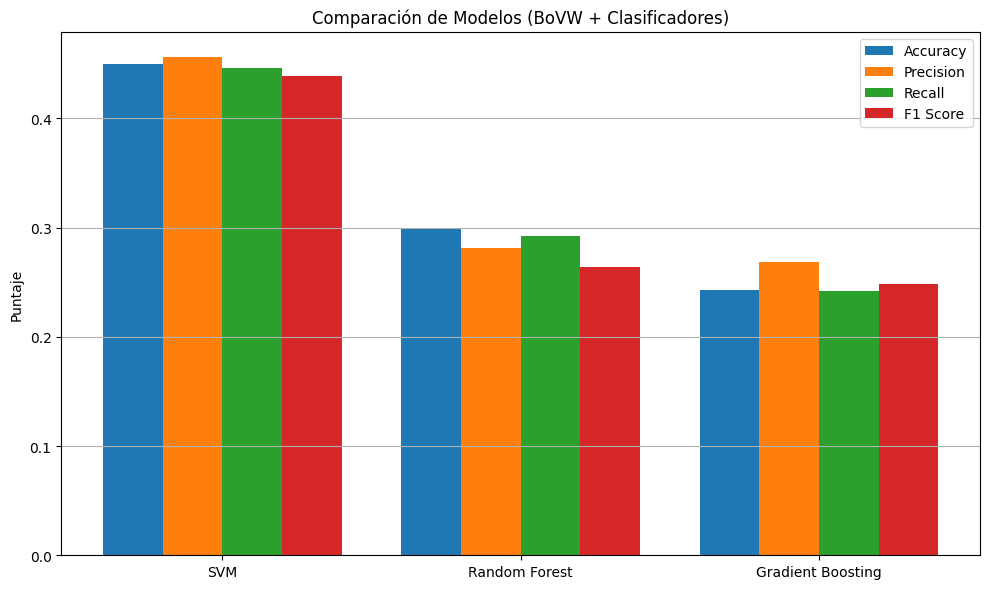

In [10]:

import matplotlib.pyplot as plt

# Graficar
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(metricas['Modelo']))
width = 0.2

ax.bar(x - 1.5*width, metricas['Accuracy'], width, label='Accuracy')
ax.bar(x - 0.5*width, metricas['Precision'], width, label='Precision')
ax.bar(x + 0.5*width, metricas['Recall'], width, label='Recall')
ax.bar(x + 1.5*width, metricas['F1 Score'], width, label='F1 Score')

ax.set_ylabel('Puntaje')
ax.set_title('Comparación de Modelos (BoVW + Clasificadores)')
ax.set_xticks(x)
ax.set_xticklabels(metricas['Modelo'])
ax.legend()
plt.tight_layout()
plt.grid(axis='y')

plt.show()

In [11]:
metricas

{'Modelo': ['SVM', 'Random Forest', 'Gradient Boosting'],
 'Accuracy': [0.45, 0.3, 0.24333333333333335],
 'Precision': [0.45649803566194286, 0.2810073162704742, 0.2689244819507977],
 'Recall': [0.44666074723350263, 0.2920939827286577, 0.2421429464927917],
 'F1 Score': [0.43919435899301723, 0.26422187522032725, 0.2481337064869216]}

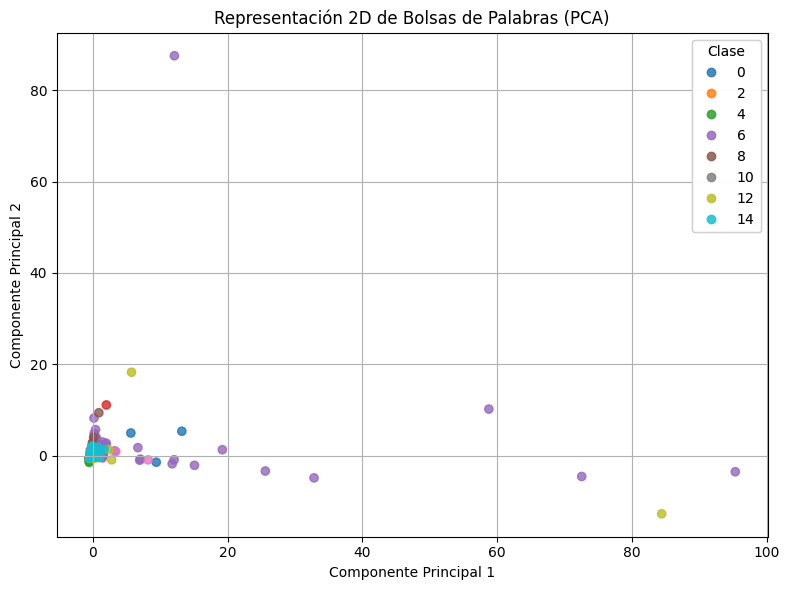

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)  

# Crear gráfico en 2D
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='tab10', alpha=0.8)

# Añadir leyenda por clase
legend = ax.legend(*scatter.legend_elements(), title="Clase")
ax.add_artist(legend)

ax.set_title("Representación 2D de Bolsas de Palabras (PCA)")
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
plt.grid(True)
plt.tight_layout()
plt.show()

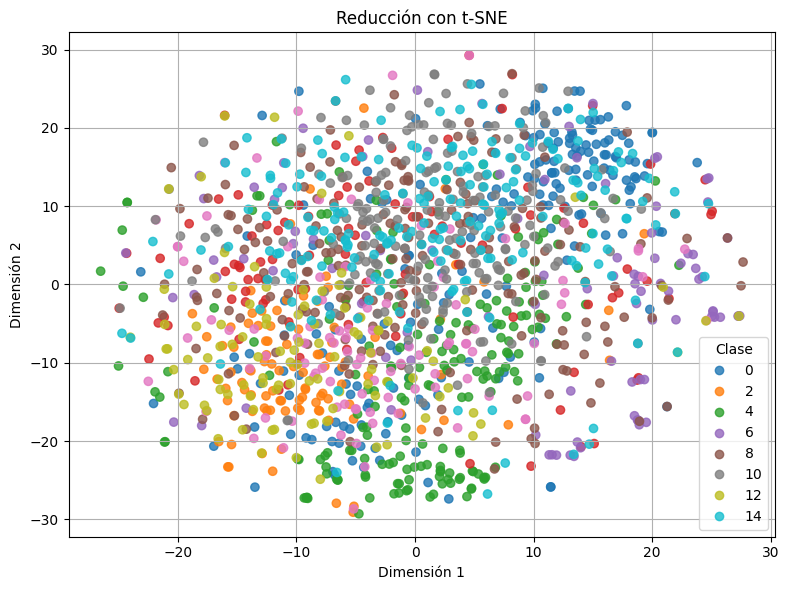

In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='tab10', alpha=0.8)
plt.legend(*scatter.legend_elements(), title="Clase")
plt.title("Reducción con t-SNE")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")
plt.grid(True)
plt.tight_layout()
plt.show()


Modelo con menos dimenciones 

In [6]:
import numpy as np
from sklearn.decomposition import PCA

def reduce_dimensions(train_recortado, target_dimension=97):

    reduced_train = []

    # Iterar sobre las clases
    for clase in train_recortado:
        reduced_clase = []  # Esta lista almacenará los descriptores reducidos de las imágenes de la clase
        
        # Iterar sobre cada imagen de la clase
        for imagen in clase:
            # Aplicar PCA para reducir la dimensionalidad de los descriptores de cada imagen
            pca = PCA(n_components=target_dimension)
            reduced_imagen = pca.fit_transform(imagen)  # Aplicar PCA a los descriptores de la imagen
            
            # Agregar los descriptores reducidos a la lista de descriptores de la clase
            reduced_clase.append(reduced_imagen)
        
        # Agregar los descriptores reducidos de la clase a la lista general
        reduced_train.append(reduced_clase)
    
    return reduced_train


In [7]:
red_train=reduce_dimensions(train_recortado, target_dimension=30)



In [8]:
from sklearn.cluster import KMeans
import numpy as np


descriptores_individuales = []

for clase in red_train:
    for imagen in clase:
        descriptores_individuales.extend(imagen) 

descriptores_individuales = np.array(descriptores_individuales)  

k = 1000  
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(descriptores_individuales)



KMeans(n_clusters=1000, random_state=42)

In [9]:
from collections import Counter
import numpy as np


k = kmeans.n_clusters
bags_of_words = []

for clase in red_train:
    clase_histogramas = []
    for imagen in clase:

        
        # Predecir a qué grupo pertenece cada descriptor
        predicciones = kmeans.predict(imagen)  

        # Contar ocurrencias de cada grupo
        contador = Counter(predicciones)

        # Crear histograma 
        histograma = np.zeros(k)
        for cluster_id, count in contador.items():
            histograma[cluster_id] = count

        clase_histogramas.append(histograma)
    bags_of_words.append(clase_histogramas)


In [10]:
import numpy as np

X = []
y = []

for i, clase in enumerate(bags_of_words): 
    for histograma in clase:
        X.append(histograma)
        y.append(i)

X = np.array(X)  
y = np.array(y) 


In [27]:


# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Modelos a evaluar
modelos = {
    'SVM': SVC(kernel='rbf', C=10, gamma=0.01, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

# Métricas por modelo
metricas = {'Modelo': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    metricas['Modelo'].append(nombre)
    metricas['Accuracy'].append(accuracy_score(y_test, y_pred))
    metricas['Precision'].append(precision_score(y_test, y_pred, average='macro'))
    metricas['Recall'].append(recall_score(y_test, y_pred, average='macro'))
    metricas['F1 Score'].append(f1_score(y_test, y_pred, average='macro'))



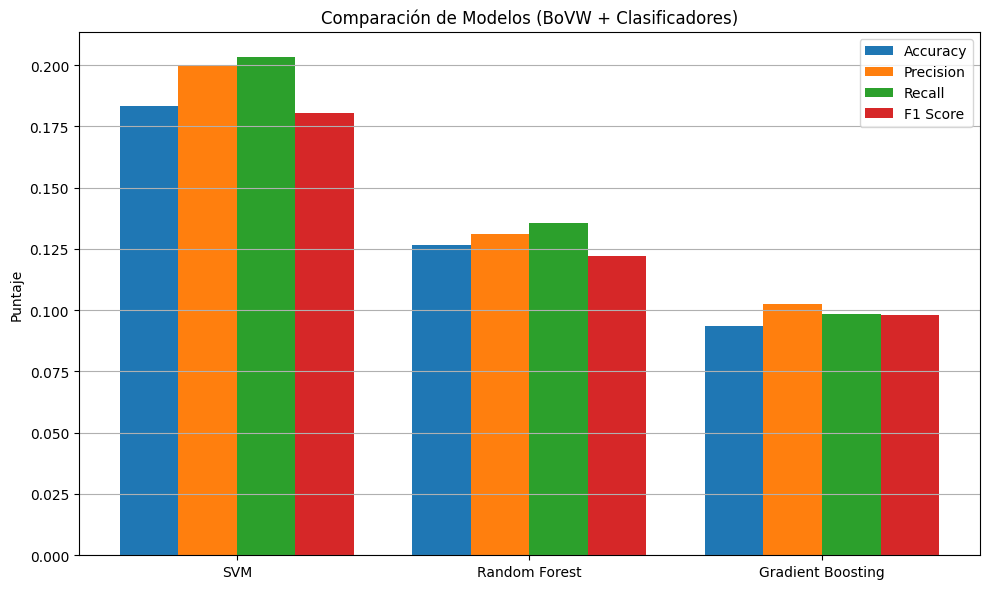

In [28]:

import matplotlib.pyplot as plt

# Graficar
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(metricas['Modelo']))
width = 0.2

ax.bar(x - 1.5*width, metricas['Accuracy'], width, label='Accuracy')
ax.bar(x - 0.5*width, metricas['Precision'], width, label='Precision')
ax.bar(x + 0.5*width, metricas['Recall'], width, label='Recall')
ax.bar(x + 1.5*width, metricas['F1 Score'], width, label='F1 Score')

ax.set_ylabel('Puntaje')
ax.set_title('Comparación de Modelos (BoVW + Clasificadores)')
ax.set_xticks(x)
ax.set_xticklabels(metricas['Modelo'])
ax.legend()
plt.tight_layout()
plt.grid(axis='y')

plt.show()

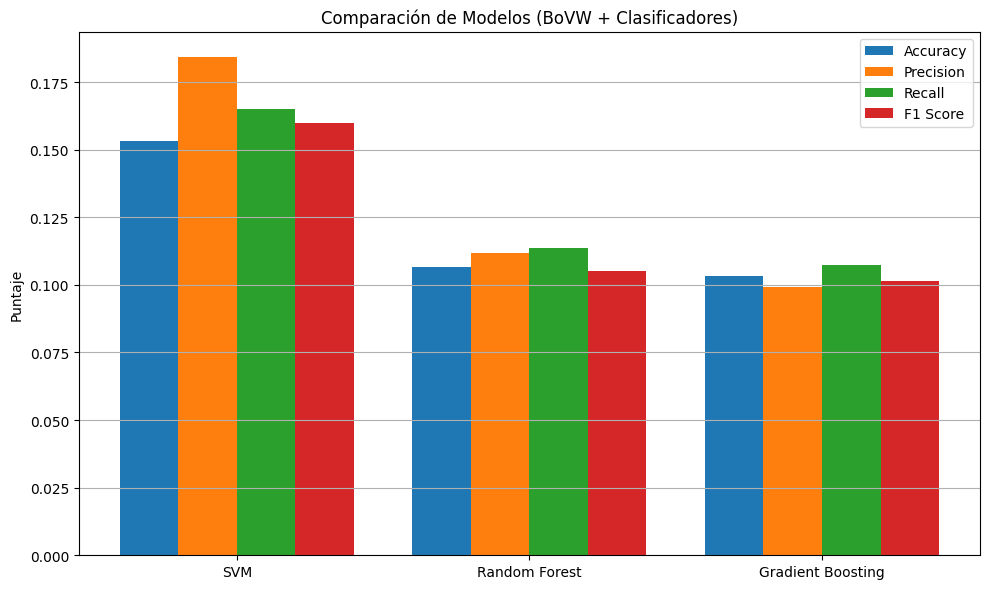

In [22]:

import matplotlib.pyplot as plt

# Graficar
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(metricas['Modelo']))
width = 0.2

ax.bar(x - 1.5*width, metricas['Accuracy'], width, label='Accuracy')
ax.bar(x - 0.5*width, metricas['Precision'], width, label='Precision')
ax.bar(x + 0.5*width, metricas['Recall'], width, label='Recall')
ax.bar(x + 1.5*width, metricas['F1 Score'], width, label='F1 Score')

ax.set_ylabel('Puntaje')
ax.set_title('Comparación de Modelos (BoVW + Clasificadores)')
ax.set_xticks(x)
ax.set_xticklabels(metricas['Modelo'])
ax.legend()
plt.tight_layout()
plt.grid(axis='y')

plt.show()

Reduciendo las bolsas de caracteristicas


In [ ]:
import numpy as np

# Si interpretamos cada columna del histograma con una palabra
num_palabras = bags_of_words[0][0].shape[0]

#Cada grupo de indices representa un tipo de imagen 'bedroom', etc. y esto podemos usarlo como analogía a un autor
frecuencias_autores = []
for autor_docs in bags_of_words:
    #
    suma = np.sum(autor_docs, axis=0)
    frecuencias_autores.append(suma)


In [ ]:
# Número de palabras a eliminar por autor
top_n = 30

# Lista con los índices de palabras más repetidas para cada autor
palabras_mas_frecuentes = []
for suma in frecuencias_autores:
    indices = np.argsort(-suma)[:top_n]  
    palabras_mas_frecuentes.append(set(indices))


In [ ]:
from collections import Counter

# Aplanamos todas las palabras frecuentes de todos los autores
todas_las_palabras = [palabra for conjunto in palabras_mas_frecuentes for palabra in conjunto]

# Contamos cuántos autores tienen cada palabra entre sus más frecuentes
conteo_autores = Counter(todas_las_palabras)

# Nos quedamos con las que están en 7 autores o menos
palabras_no_comunes = [palabra for palabra, conteo in conteo_autores.items() if conteo <= 7]

# Ordenamos 
palabras_no_comunes = sorted(palabras_no_comunes)

print(f"Número de palabras poco comunes (<= 7 autores): {len(palabras_no_comunes)}")
print("Ejemplos:", palabras_no_comunes[:10])


Número de palabras poco comunes (<= 7 autores): 339
Ejemplos: [11, 14, 16, 21, 24, 26, 27, 30, 32, 33]


In [92]:
bags_of_words_filtrado = []

for autor_docs in bags_of_words:
    autor_filtrado = []
    for doc in autor_docs:
        # Conservar solo los índices en palabras_no_comunes
        doc_filtrado = doc[palabras_no_comunes]
        autor_filtrado.append(doc_filtrado)
    bags_of_words_filtrado.append(autor_filtrado)


In [93]:
import numpy as np

X = []
y = []

for i, clase in enumerate(bags_of_words_filtrado): 
    for histograma in clase:
        X.append(histograma)
        y.append(i)

X = np.array(X)  
y = np.array(y) 


In [94]:


# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Modelos a evaluar
modelos = {
    'SVM': SVC(kernel='rbf', C=10, gamma=0.01, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

# Métricas por modelo
metricas = {'Modelo': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    metricas['Modelo'].append(nombre)
    metricas['Accuracy'].append(accuracy_score(y_test, y_pred))
    metricas['Precision'].append(precision_score(y_test, y_pred, average='macro'))
    metricas['Recall'].append(recall_score(y_test, y_pred, average='macro'))
    metricas['F1 Score'].append(f1_score(y_test, y_pred, average='macro'))


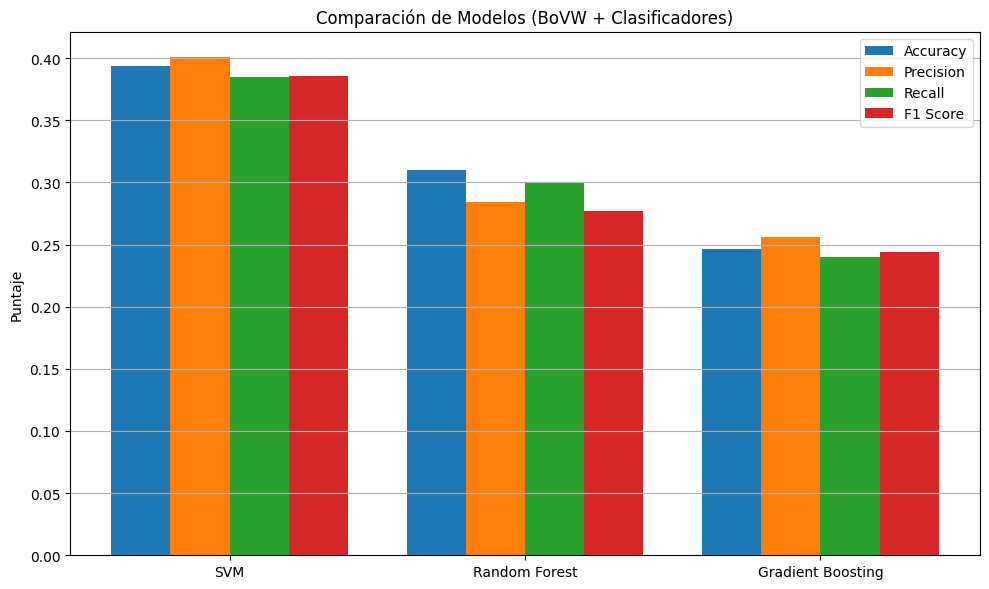

In [95]:

import matplotlib.pyplot as plt

# Graficar
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(metricas['Modelo']))
width = 0.2

ax.bar(x - 1.5*width, metricas['Accuracy'], width, label='Accuracy')
ax.bar(x - 0.5*width, metricas['Precision'], width, label='Precision')
ax.bar(x + 0.5*width, metricas['Recall'], width, label='Recall')
ax.bar(x + 1.5*width, metricas['F1 Score'], width, label='F1 Score')

ax.set_ylabel('Puntaje')
ax.set_title('Comparación de Modelos (BoVW + Clasificadores)')
ax.set_xticks(x)
ax.set_xticklabels(metricas['Modelo'])
ax.legend()
plt.tight_layout()
plt.grid(axis='y')

plt.show()

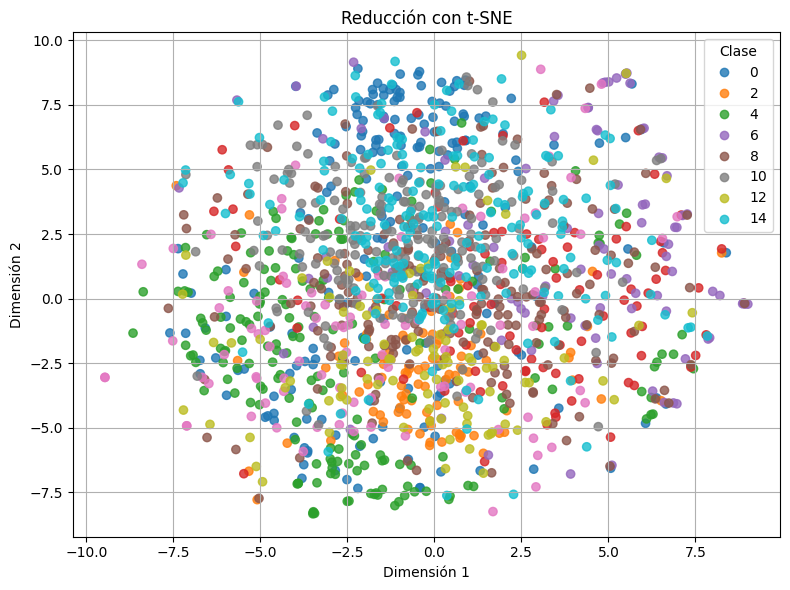

In [96]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='tab10', alpha=0.8)
plt.legend(*scatter.legend_elements(), title="Clase")
plt.title("Reducción con t-SNE")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")
plt.grid(True)
plt.tight_layout()
plt.show()


Reduciendo tanto los vectores como las bolsas de características.

In [12]:
import numpy as np

# Si interpretamos cada columna del histograma con una palabra
num_palabras = bags_of_words[0][0].shape[0]

#Cada grupo de indices representa un tipo de imagen 'bedroom', etc. y esto podemos usarlo como analogía a un autor
frecuencias_autores = []
for autor_docs in bags_of_words:
    #
    suma = np.sum(autor_docs, axis=0)
    frecuencias_autores.append(suma)


In [13]:
# Número de palabras a eliminar por autor
top_n = 30

# Lista con los índices de palabras más repetidas para cada autor
palabras_mas_frecuentes = []
for suma in frecuencias_autores:
    indices = np.argsort(-suma)[:top_n]  
    palabras_mas_frecuentes.append(set(indices))

In [14]:
from collections import Counter

# Aplanamos todas las palabras frecuentes de todos los autores
todas_las_palabras = [palabra for conjunto in palabras_mas_frecuentes for palabra in conjunto]

# Contamos cuántos autores tienen cada palabra entre sus más frecuentes
conteo_autores = Counter(todas_las_palabras)

# Nos quedamos con las que están en 7 autores o menos
palabras_no_comunes = [palabra for palabra, conteo in conteo_autores.items() if conteo <= 7]

# Ordenamos 
palabras_no_comunes = sorted(palabras_no_comunes)

print(f"Número de palabras poco comunes (<= 7 autores): {len(palabras_no_comunes)}")
print("Ejemplos:", palabras_no_comunes[:10])


Número de palabras poco comunes (<= 7 autores): 311
Ejemplos: [2, 3, 7, 13, 16, 18, 22, 23, 26, 27]


In [15]:
bags_of_words_filtrado = []

for autor_docs in bags_of_words:
    autor_filtrado = []
    for doc in autor_docs:
        # Conservar solo los índices en palabras_no_comunes
        doc_filtrado = doc[palabras_no_comunes]
        autor_filtrado.append(doc_filtrado)
    bags_of_words_filtrado.append(autor_filtrado)

In [16]:
import numpy as np

X = []
y = []

for i, clase in enumerate(bags_of_words_filtrado): 
    for histograma in clase:
        X.append(histograma)
        y.append(i)

X = np.array(X)  
y = np.array(y) 

In [19]:

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Modelos a evaluar
modelos = {
    'SVM': SVC(kernel='rbf', C=10, gamma=0.01, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

# Métricas por modelo
metricas = {'Modelo': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    metricas['Modelo'].append(nombre)
    metricas['Accuracy'].append(accuracy_score(y_test, y_pred))
    metricas['Precision'].append(precision_score(y_test, y_pred, average='macro'))
    metricas['Recall'].append(recall_score(y_test, y_pred, average='macro'))
    metricas['F1 Score'].append(f1_score(y_test, y_pred, average='macro'))

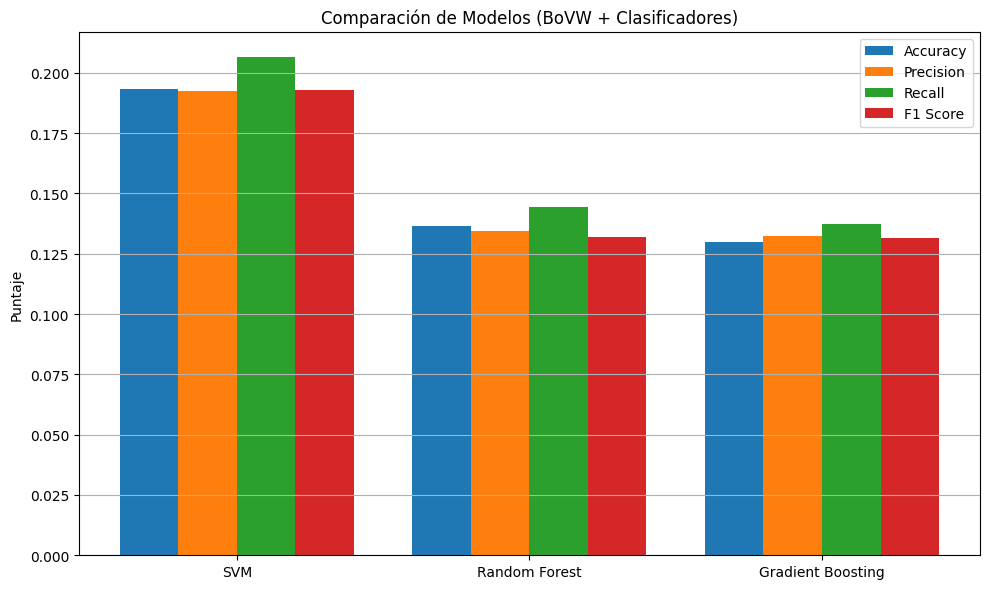

In [20]:

import matplotlib.pyplot as plt

# Graficar
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(metricas['Modelo']))
width = 0.2

ax.bar(x - 1.5*width, metricas['Accuracy'], width, label='Accuracy')
ax.bar(x - 0.5*width, metricas['Precision'], width, label='Precision')
ax.bar(x + 0.5*width, metricas['Recall'], width, label='Recall')
ax.bar(x + 1.5*width, metricas['F1 Score'], width, label='F1 Score')

ax.set_ylabel('Puntaje')
ax.set_title('Comparación de Modelos (BoVW + Clasificadores)')
ax.set_xticks(x)
ax.set_xticklabels(metricas['Modelo'])
ax.legend()
plt.tight_layout()
plt.grid(axis='y')

plt.show()

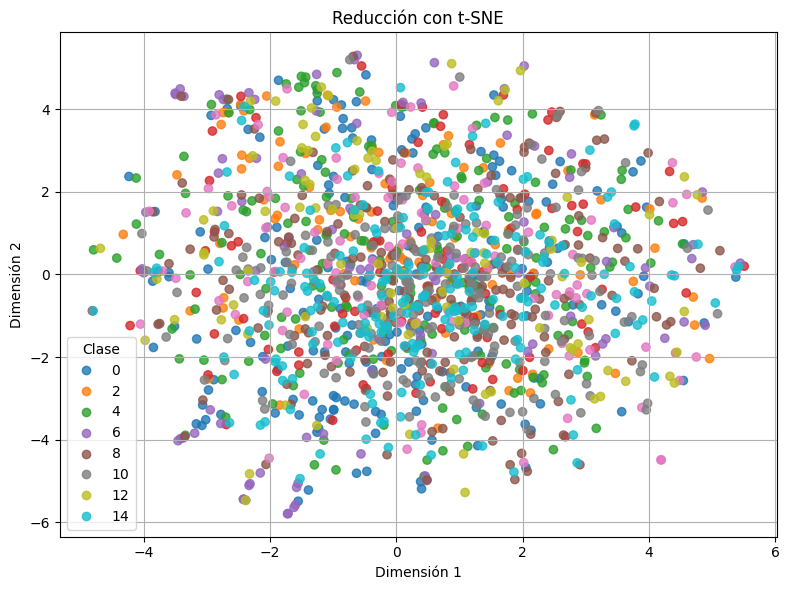

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='tab10', alpha=0.8)
plt.legend(*scatter.legend_elements(), title="Clase")
plt.title("Reducción con t-SNE")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")
plt.grid(True)
plt.tight_layout()
plt.show()

Matrices de confusion 

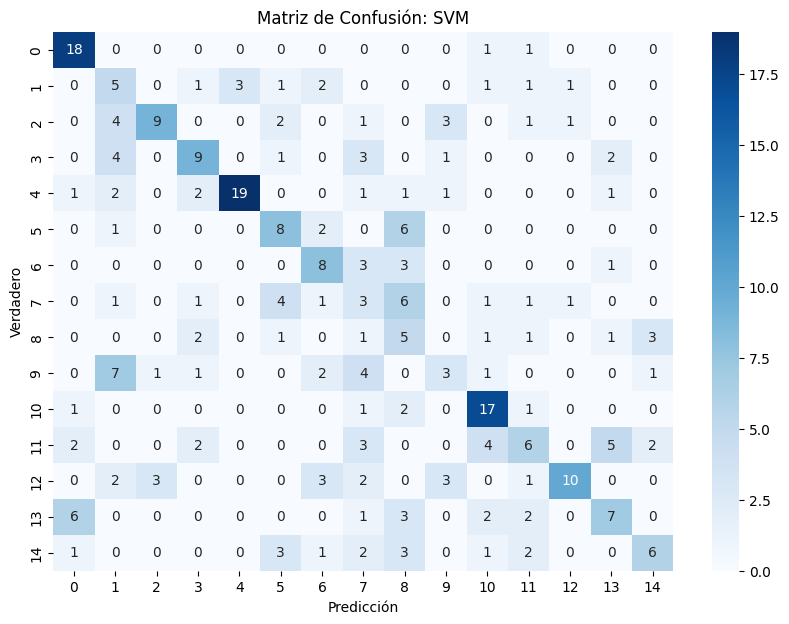

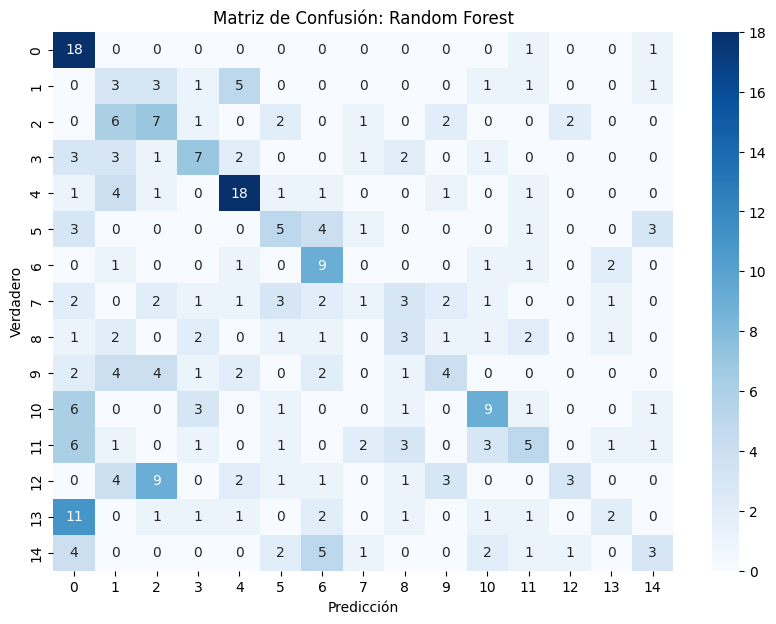

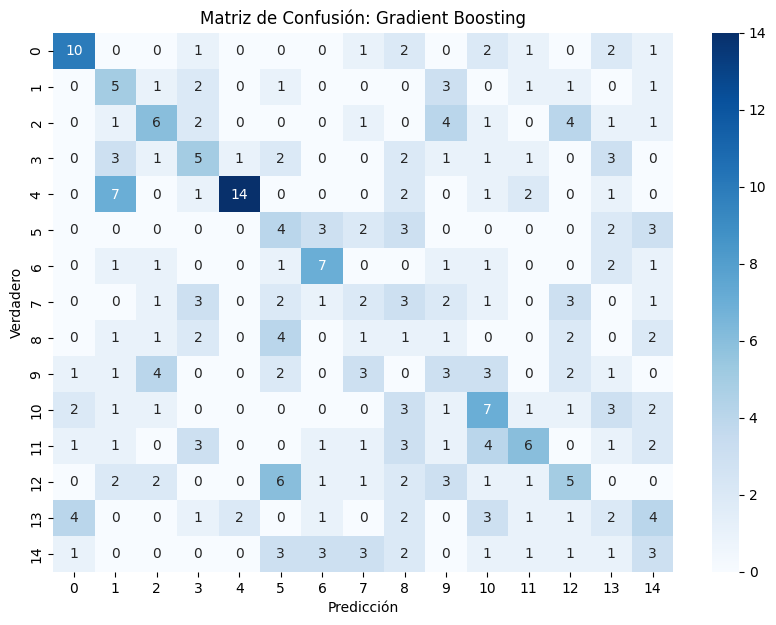

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizar como heatmaps
for nombre, modelo in modelos.items():
    y_pred = modelo.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de Confusión: {nombre}")
    plt.xlabel("Predicción")
    plt.ylabel("Verdadero")
    plt.show()



In [13]:
# Métricas por modelo
metricas = {'Modelo': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    metricas['Modelo'].append(nombre)
    metricas['Accuracy'].append(accuracy_score(y_test, y_pred))
    metricas['Precision'].append(precision_score(y_test, y_pred, average='macro'))
    metricas['Recall'].append(recall_score(y_test, y_pred, average='macro'))
    metricas['F1 Score'].append(f1_score(y_test, y_pred, average='macro'))

In [14]:
metricas

{'Modelo': ['SVM', 'Random Forest', 'Gradient Boosting'],
 'Accuracy': [0.44333333333333336, 0.3233333333333333, 0.26666666666666666],
 'Precision': [0.45835190993128433, 0.3180912846470122, 0.28086792987452563],
 'Recall': [0.43494283837937087, 0.31789978511340744, 0.26150574743454],
 'F1 Score': [0.43048704474192667, 0.28919829760932, 0.26520985922688706]}

Ejercicio 2

In [18]:

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

categorias = ['rec.sport.hockey', 'sci.space', 'comp.graphics', 'talk.politics.misc']
datos = fetch_20newsgroups(subset='all', categories=categorias, remove=('headers', 'footers', 'quotes'))

vectorizador = TfidfVectorizer(stop_words='english', max_features=800)
X = vectorizador.fit_transform(datos.data)
y = datos.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

modelo_svm_lineal = SVC(kernel='linear')
modelo_svm_lineal.fit(X_train, y_train)
acc_lineal = accuracy_score(y_test, modelo_svm_lineal.predict(X_test))

modelo_svm_rbf = SVC(kernel='rbf')
modelo_svm_rbf.fit(X_train, y_train)
acc_rbf = accuracy_score(y_test, modelo_svm_rbf.predict(X_test))

X_train_norm = normalize(X_train, norm='l2', axis=1)
X_test_norm = normalize(X_test, norm='l2', axis=1)
K_train = cosine_similarity(X_train_norm)
K_test = cosine_similarity(X_test_norm, X_train_norm)

modelo_svm_coseno = SVC(kernel='precomputed')
modelo_svm_coseno.fit(K_train, y_train)
acc_coseno = accuracy_score(y_test, modelo_svm_coseno.predict(K_test))

resultados = pd.DataFrame({
    "Kernel": ["Lineal", "RBF", "Coseno"],
    "Precisión": [acc_lineal, acc_rbf, acc_coseno]
})
print(resultados)

   Kernel  Precisión
0  Lineal   0.825156
1     RBF   0.834077
2  Coseno   0.825156
